In [40]:
import pandas as pd
import os

# --- 1. 配置参数 ---
# 请根据您的实际情况修改文件路径和工作表名称
file_path = r"E:\A智网\8.27湖北重点行业变化分析\同比版本.xlsx"
source_sheet_name = "基础数据"
output_sheet_name = "省份筛选"

# --- 2. 读取和预处理数据 ---
try:
    print(f"正在读取文件: {file_path}")
    # 读取指定sheet的数据
    df = pd.read_excel(file_path, sheet_name=source_sheet_name)
    print("文件读取成功，开始处理数据...")

    # 自动识别月份字段（例如 '202503', '202504' 等）
    # 假设月份字段是所有6位数的数字列
    month_cols = [col for col in df.columns if isinstance(col, (int, str)) and str(col).isdigit() and len(str(col)) == 6]
    
    # 将月份字段统一转换为字符串，防止后续操作因类型问题出错
    df.rename(columns={col: str(col) for col in month_cols}, inplace=True)
    month_cols = [str(col) for col in month_cols]

    # 清理可能存在的空格
    df['省份'] = df['省份'].str.strip()
    df['行业名称'] = df['行业名称'].str.strip()

    # 计算用于排序的“3-8月电量总和”
    df['总电量'] = df[month_cols].sum(axis=1)

    # --- 3. 计算“全国”数据 ---
    # 按行业分组，对每个月的电量求和
    national_df = df.groupby(['行业序号', '行业名称'])[month_cols].sum().reset_index()
    # 添加“省份”列，并赋值为“全国”
    national_df['省份'] = '全国'
    print("已计算各行业全国总电量。")

    # --- 4. 筛选各行业Top5省份及湖北省数据 ---
    # 创建一个空的DataFrame用于存放最终筛选结果
    top_provinces_list = []

    # 按“行业序号”和“行业名称”进行分组
    for (industry_code, industry_name), group in df.groupby(['行业序号', '行业名称']):
        # 对每个行业内部的省份按“总电量”降序排列
        group_sorted = group.sort_values(by='总电量', ascending=False)
        
        # 提取电量前五的省份
        top5 = group_sorted.head(5)
        
        # 提取湖北省的数据
        hubei_data = group[group['省份'] == '湖北']
        
        # 检查湖北省是否已在前五名中
        is_hubei_in_top5 = '湖北' in top5['省份'].values
        
        # 如果湖北省不在前五且存在湖北省数据，则将其添加进去
        if not is_hubei_in_top5 and not hubei_data.empty:
            final_group = pd.concat([top5, hubei_data])
        else:
            final_group = top5
            
        top_provinces_list.append(final_group)

    # 将所有行业的筛选结果合并成一个DataFrame
    top_provinces_df = pd.concat(top_provinces_list)
    print("已筛选出各行业Top5省份及湖北省数据。")

    # --- 5. 合并与整理最终结果 ---
    # 定义最终输出的列顺序
    output_columns = ['省份', '行业序号', '行业名称'] + month_cols
    
    # 组合“全国”数据和“各省”数据，并只保留需要的列
    final_df = pd.concat([national_df, top_provinces_df])[output_columns]

    # 为了美观，对结果进行排序：按行业序号升序，在每个行业内，“全国”排第一，其余按总电量降序
    # 重新计算总电量用于排序
    final_df['总电量'] = final_df[month_cols].sum(axis=1)
    # 创建一个辅助列用于排序，“全国”为0，其他为1
    final_df['排序辅助'] = final_df['省份'].apply(lambda x: 0 if x == '全国' else 1)
    
    # 执行排序
    final_df_sorted = final_df.sort_values(
        by=['行业序号', '排序辅助', '总电量'],
        ascending=[True, True, False]
    )

    # 删除用于排序的辅助列
    final_df_sorted = final_df_sorted.drop(columns=['总电量', '排序辅助'])
    print("数据整合与排序完成。")

    # --- 6. 写入到新的Excel Sheet ---
    print(f"正在将结果写入到文件: {file_path} 的新工作表: {output_sheet_name}")
    # 使用 ExcelWriter 以“追加”模式打开文件，如果目标sheet已存在则替换它
    with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        final_df_sorted.to_excel(writer, sheet_name=output_sheet_name, index=False)

    print("--- 操作成功！---")
    print(f"结果已保存在 '{os.path.basename(file_path)}' 文件的 '{output_sheet_name}' 工作表中。")

except FileNotFoundError:
    print(f"错误：文件未找到，请检查路径是否正确: {file_path}")
except Exception as e:
    print(f"处理过程中发生错误: {e}")

正在读取文件: E:\A智网\8.27湖北重点行业变化分析\同比版本.xlsx
文件读取成功，开始处理数据...
已计算各行业全国总电量。
已筛选出各行业Top5省份及湖北省数据。
数据整合与排序完成。
正在将结果写入到文件: E:\A智网\8.27湖北重点行业变化分析\同比版本.xlsx 的新工作表: 省份筛选
--- 操作成功！---
结果已保存在 '同比版本.xlsx' 文件的 '省份筛选' 工作表中。


In [38]:
import pandas as pd
import numpy as np
import os

# --- 1. 配置参数 ---
# 文件路径保持不变
file_path = r"E:\A智网\8.27湖北重点行业变化分析\电气机械和房地产.xlsx"
# 源工作表现在是上一步的结果
source_sheet_name = "26天"
# 输出一个新的工作表，名称清晰
output_sheet_name = "累计环比增速"

# --- 2. 读取预处理好的数据 ---
try:
    print(f"正在读取已处理好的数据: '{source_sheet_name}' sheet...")
    df = pd.read_excel(file_path, sheet_name=source_sheet_name)
    print("数据读取成功，开始计算累计环比增速...")

    # --- 3. 识别列并确定基期 ---
    # 自动识别月份字段
    month_cols = [col for col in df.columns if isinstance(col, (int, str)) and str(col).isdigit() and len(str(col)) == 6]
    
    # 将月份字段统一为字符串并排序，确保时间顺序
    df.rename(columns={col: str(col) for col in month_cols}, inplace=True)
    month_cols = sorted([str(col) for col in month_cols]) # 排序以确定第一个月为基期

    # 确定基期月份（第一个月）
    base_month = month_cols[0]
    print(f"已确定基期月份为: {base_month}")

    # 识别标识列
    id_cols = ['省份', '行业序号', '行业名称']

    # --- 4. 核心计算：累计环比增速 ---
    # 创建一个用于存放结果的DataFrame，先复制标识列
    result_df = df[id_cols].copy()

    # 基期（第一个月）的增速定义为0，这里用'-'表示
    result_df[base_month] = '-'

    # 遍历从第二个月开始的所有月份进行计算
    for month in month_cols[1:]:
        # 获取基期和当期的用电量数据
        base_values = df[base_month]
        current_values = df[month]
        
        # 计算公式：(当月值 - 基期值) / 基期值
        # 使用 np.where 处理基期值为0的特殊情况，避免除以零错误
        growth_rate = np.where(
            base_values == 0, 
            np.nan,  # 如果基期值为0，则增长率无意义，设为空值(NaN)
            (current_values - base_values) / base_values
        )
        result_df[month] = growth_rate
    
    print("累计环比增速计算完成，正在格式化输出...")

    # --- 5. 格式化输出 ---
    # 遍历所有计算出的月份列，将小数格式化为百分比字符串
    for col in month_cols[1:]:
        result_df[col] = result_df[col].apply(
            lambda x: f"{x:.2%}" if pd.notna(x) else '-'
        )
    
    # 因为源数据已经排好序，所以这里不需要再排序了
    final_df = result_df

    # --- 6. 写入到新的Excel Sheet ---
    print(f"正在将结果写入到文件: {file_path} 的新工作表: {output_sheet_name}")
    with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        final_df.to_excel(writer, sheet_name=output_sheet_name, index=False)

    print("--- 操作成功！---")
    print(f"基于分析结果计算的累计环比增速已保存在 '{os.path.basename(file_path)}' 文件的 '{output_sheet_name}' 工作表中。")

except FileNotFoundError:
    print(f"错误：文件未找到，请检查路径是否正确: {file_path}")
except ValueError as e:
    if f"Worksheet '{source_sheet_name}' not found" in str(e):
        print(f"错误：找不到名为 '{source_sheet_name}' 的工作表。请先运行第一个脚本生成该表。")
    else:
        print(f"处理过程中发生值错误: {e}")
except Exception as e:
    print(f"处理过程中发生未知错误: {e}")

正在读取已处理好的数据: '26天' sheet...
数据读取成功，开始计算累计环比增速...
已确定基期月份为: 202503
累计环比增速计算完成，正在格式化输出...
正在将结果写入到文件: E:\A智网\8.27湖北重点行业变化分析\电气机械和房地产.xlsx 的新工作表: 累计环比增速
--- 操作成功！---
基于分析结果计算的累计环比增速已保存在 '电气机械和房地产.xlsx' 文件的 '累计环比增速' 工作表中。


正在读取数据: '同比' sheet...
数据读取成功。
已创建文件夹: 'E:\A智网\8.27湖北重点行业变化分析\同比分析' 用于存放图表。
数据已成功转换为数值格式，准备绘图...
正在为行业 '纺织' 生成图表...
图表已保存至: E:\A智网\8.27湖北重点行业变化分析\同比分析\纺织_增速趋势图.png
正在为行业 '化工' 生成图表...
图表已保存至: E:\A智网\8.27湖北重点行业变化分析\同比分析\化工_增速趋势图.png
正在为行业 '医药制造' 生成图表...
图表已保存至: E:\A智网\8.27湖北重点行业变化分析\同比分析\医药制造_增速趋势图.png
正在为行业 '建材' 生成图表...
图表已保存至: E:\A智网\8.27湖北重点行业变化分析\同比分析\建材_增速趋势图.png
正在为行业 '钢铁' 生成图表...
图表已保存至: E:\A智网\8.27湖北重点行业变化分析\同比分析\钢铁_增速趋势图.png
正在为行业 '有色金属' 生成图表...
图表已保存至: E:\A智网\8.27湖北重点行业变化分析\同比分析\有色金属_增速趋势图.png
正在为行业 '金属制品' 生成图表...
图表已保存至: E:\A智网\8.27湖北重点行业变化分析\同比分析\金属制品_增速趋势图.png
正在为行业 '通用设备' 生成图表...
图表已保存至: E:\A智网\8.27湖北重点行业变化分析\同比分析\通用设备_增速趋势图.png
正在为行业 '专用设备' 生成图表...
图表已保存至: E:\A智网\8.27湖北重点行业变化分析\同比分析\专用设备_增速趋势图.png
正在为行业 '汽车' 生成图表...
图表已保存至: E:\A智网\8.27湖北重点行业变化分析\同比分析\汽车_增速趋势图.png
正在为行业 '铁路船舶' 生成图表...
图表已保存至: E:\A智网\8.27湖北重点行业变化分析\同比分析\铁路船舶_增速趋势图.png
正在为行业 '电气机械' 生成图表...
图表已保存至: E:\A智网\8.27湖北重点行业变化分析\同比分析\电气机械_增速趋势图.png
正在为行业 '计算机' 生成图表...


KeyboardInterrupt: 

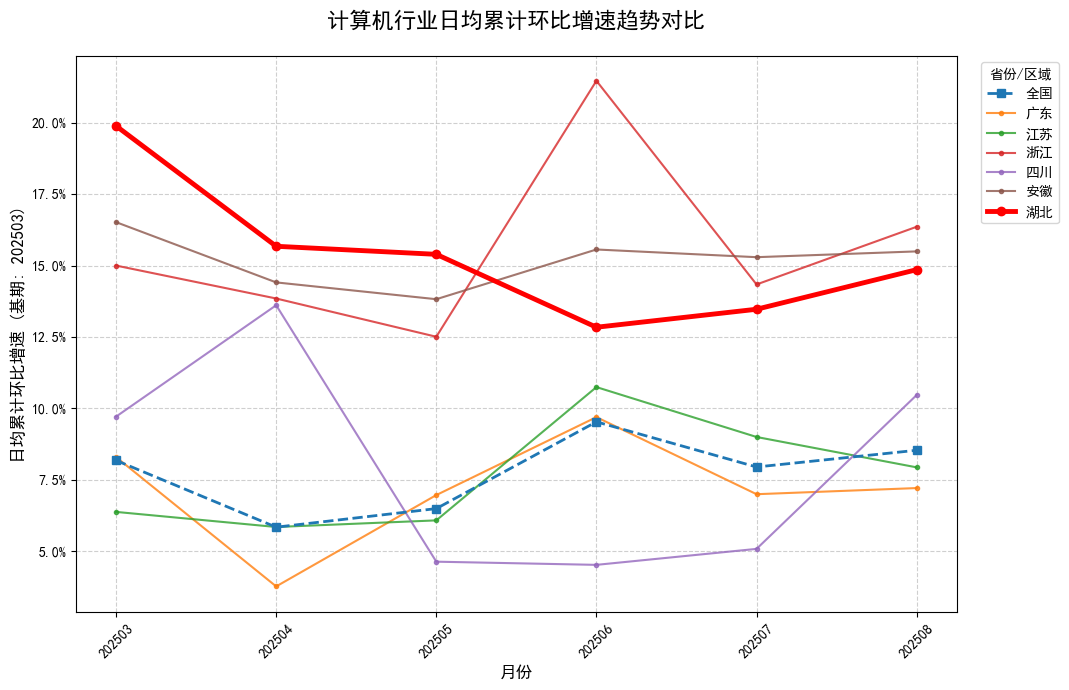

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import PercentFormatter

# --- 1. 配置参数 ---
file_path = r"E:\A智网\8.27湖北重点行业变化分析\同比版本.xlsx"
# 读取上一步生成的、包含累计环比增速的工作表
source_sheet_name = "同比"
# 创建一个文件夹来存放所有生成的图表
output_chart_folder = r"E:\A智网\8.27湖北重点行业变化分析\同比分析"

# --- 2. 数据加载与预处理 ---
try:
    print(f"正在读取数据: '{source_sheet_name}' sheet...")
    df = pd.read_excel(file_path, sheet_name=source_sheet_name)
    print("数据读取成功。")

    # 创建输出图表的文件夹（如果不存在）
    if not os.path.exists(output_chart_folder):
        os.makedirs(output_chart_folder)
        print(f"已创建文件夹: '{output_chart_folder}' 用于存放图表。")

    # 识别月份列和标识列
    month_cols = [col for col in df.columns if isinstance(col, (int, str)) and str(col).isdigit() and len(str(col)) == 6]
    month_cols = sorted([str(col) for col in month_cols])

    # **关键步骤：将百分比字符串转换回可供绘图的数值**
    def convert_to_float(value):
        """将 '5.21%' 或 '-' 这样的字符串转换为浮点数 0.0521 或 0.0"""
        if isinstance(value, str):
            if value.strip() == '-':
                return 0.0
            try:
                # 移除 '%' 符号，转换为浮点数，然后除以100
                return float(value.strip().replace('%', '')) / 100
            except ValueError:
                return 0.0
        # 如果已经是数字，直接返回
        return float(value)

    # 对所有月份列应用这个转换函数
    for col in month_cols:
        df[col] = df[col].apply(convert_to_float)
    
    print("数据已成功转换为数值格式，准备绘图...")

    # 设置matplotlib的中文字体，以防图表中的中文显示为方框
    # 你可以根据你的操作系统选择一个已安装的中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统常用'SimHei'（黑体）
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题

    # --- 3. 循环为每个行业绘制并保存图表 ---
    # 获取所有唯一的行业名称
    unique_industries = df['行业名称'].unique()

    for industry in unique_industries:
        print(f"正在为行业 '{industry}' 生成图表...")
        
        # 筛选出当前行业的数据
        industry_df = df[df['行业名称'] == industry]

        # 创建一个新的图表和坐标轴
        fig, ax = plt.subplots(figsize=(12, 7))

        # 遍历该行业内的每个省份（或全国）并绘制折线
        for index, row in industry_df.iterrows():
            province = row['省份']
            growth_data = row[month_cols]
            
            # --- 核心：对湖北省进行特殊处理 ---
            if province == '湖北':
                ax.plot(month_cols, growth_data, 
                        label=province, 
                        linewidth=3.5,  # 标粗线条
                        marker='o',       # 添加标记点
                        markersize=6,
                        color='red',      # 使用醒目的红色
                        zorder=10)        # zorder确保该线条在最上层
            elif province == '全国':
                ax.plot(month_cols, growth_data, 
                        label=province, 
                        linewidth=2.0, 
                        linestyle='--', # 使用虚线区分“全国”
                        marker='s',
                        zorder=5)
            else:
                ax.plot(month_cols, growth_data, 
                        label=province, 
                        linewidth=1.5,
                        marker='.',
                        alpha=0.8) # 其他省份线条稍细，略带透明

        # --- 4. 美化图表 ---
        # 设置图表标题
        ax.set_title(f'{industry}行业同比增速趋势对比', fontsize=16, pad=20)
        
        # 设置坐标轴标签
        ax.set_xlabel('月份', fontsize=12)
        ax.set_ylabel('同比增速 (基期: ' + month_cols[0] + ')', fontsize=12)
        
        # 将Y轴格式化为百分比显示
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        
        # 添加图例
        ax.legend(title='省份/区域', bbox_to_anchor=(1.02, 1), loc='upper left')
        
        # 添加网格线
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # 旋转X轴标签，防止重叠
        plt.xticks(rotation=45)
        
        # 调整布局以防止标签被截断
        plt.tight_layout(rect=[0, 0, 0.9, 1]) # 为图例留出右侧空间

        # --- 5. 保存图表 ---
        # 创建一个对文件名安全的文件名
        safe_industry_name = industry.replace('/', '_').replace('\\', '_')
        chart_filename = os.path.join(output_chart_folder, f'{safe_industry_name}_增速趋势图.png')
        
        plt.savefig(chart_filename, dpi=600) # dpi=300 保存为高分辨率图片
        
        # 关闭当前图表，释放内存，准备绘制下一张
        plt.close(fig)
        
        print(f"图表已保存至: {chart_filename}")

    print("\n--- 所有图表生成完毕！---")

except FileNotFoundError:
    print(f"错误：文件未找到，请检查路径是否正确: {file_path}")
except ValueError as e:
    if f"Worksheet '{source_sheet_name}' not found" in str(e):
        print(f"错误：找不到名为 '{source_sheet_name}' 的工作表。请先运行前序脚本生成该表。")
    else:
        print(f"处理过程中发生值错误: {e}")
except Exception as e:
    print(f"处理过程中发生未知错误: {e}")

In [28]:
import pandas as pd
import numpy as np
import os

# --- 1. 配置参数 ---
file_path = r"E:\A智网\8.27湖北重点行业变化分析\日均累计环比增速.xlsx"
source_sheet_name = "26天"
output_sheet_name = "26天近期趋势动量分析"

try:
    # --- 2. 数据加载与预处理 ---
    print(f"正在读取数据: '{source_sheet_name}' sheet...")
    df = pd.read_excel(file_path, sheet_name=source_sheet_name)
    
    month_cols = [col for col in df.columns if isinstance(col, (int, str)) and str(col).isdigit() and len(str(col)) == 6]
    month_cols = sorted([str(col) for col in month_cols])

    # 将百分比字符串转换回数值
    def convert_to_float(value):
        if isinstance(value, str):
            if value.strip() == '-': return 0.0
            try: return float(value.strip().replace('%', '')) / 100
            except ValueError: return 0.0
        return float(value)
    
    for col in month_cols:
        df[col] = df[col].apply(convert_to_float)
    
    # --- 3. 计算月度动量 (Monthly Momentum) ---
    print("正在计算月度动量...")
    # 使用 .diff(axis=1) 可以快速计算每一行中，当前列与前一列的差值
    momentum_df = df[month_cols].diff(axis=1)
    
    # 将标识列和动量数据合并
    analysis_df = pd.concat([df[['行业名称', '省份']], momentum_df], axis=1)
    # 丢弃第一个月（因为没有上一个月可以比较，结果是NaN）
    analysis_df = analysis_df.drop(columns=[month_cols[0]])

    # --- 4. 逐行业对比湖北与全国的动量 ---
    print("正在为每个行业生成趋势对比结论...")
    final_results = []
    
    for industry_name, group in analysis_df.groupby('行业名称'):
        # 筛选出湖北和全国的数据
        hubei_momentum = group[group['省份'] == '湖北']
        national_momentum = group[group['省份'] == '全国']
        
        # 如果这个行业同时有湖北和全国的数据
        if not hubei_momentum.empty and not national_momentum.empty:
            # 将Series转换为字典，方便按月份取值
            hubei_dict = hubei_momentum.iloc[0].to_dict()
            national_dict = national_momentum.iloc[0].to_dict()
            
            # 遍历每个月份（从第二个月开始）
            for month in momentum_df.columns[1:]:
                hb_mom = hubei_dict.get(month, 0)
                na_mom = national_dict.get(month, 0)
                
                conclusion = ""
                # 方向比较
                if np.sign(hb_mom) != np.sign(na_mom) and not (hb_mom == 0 or na_mom == 0):
                    if hb_mom > 0:
                        conclusion = "趋势背离：湖北上升，全国下降"
                    else:
                        conclusion = "趋势背离：湖北下降，全国上升"
                else: # 趋势一致
                    diff = hb_mom - na_mom
                    if hb_mom > 0: # 同向增长
                        if diff > 0.001: conclusion = "同向增长 (湖北势头更强)"
                        elif diff < -0.001: conclusion = "同向增长 (湖北势头较弱)"
                        else: conclusion = "同向增长 (势头相当)"
                    else: # 同向下降
                        if diff > 0.001: conclusion = "同向下降 (湖北降幅更缓)"
                        elif diff < -0.001: conclusion = "同向下降 (湖北降幅更猛)"
                        else: conclusion = "同向下降 (降幅相当)"
                
                # 记录结果
                final_results.append({
                    '行业名称': industry_name,
                    '月份': month,
                    '湖北动量': f"{hb_mom:.2%}",
                    '全国动量': f"{na_mom:.2%}",
                    '结论': conclusion
                })

    # 创建最终的结论DataFrame
    conclusion_df = pd.DataFrame(final_results)

    # --- 5. 保存结果 ---
    print(f"正在将分析结论写入到新工作表: '{output_sheet_name}'")
    with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        conclusion_df.to_excel(writer, sheet_name=output_sheet_name, index=False)

    print(f"\n--- 分析完成！---")
    print(f"详细的月度动量对比结果已保存在 '{output_sheet_name}' 工作表中。")

except Exception as e:
    print(f"处理过程中发生错误: {e}")

正在读取数据: '26天' sheet...
正在计算月度动量...
正在为每个行业生成趋势对比结论...
正在将分析结论写入到新工作表: '26天近期趋势动量分析'

--- 分析完成！---
详细的月度动量对比结果已保存在 '26天近期趋势动量分析' 工作表中。


In [29]:
import pandas as pd
import numpy as np
import os

# --- 1. 配置参数 ---
file_path = r"E:\A智网\8.27湖北重点行业变化分析\日均累计环比增速.xlsx"
source_sheet_name = "26天"
output_sheet_name = "26天近期趋势动量分析_v2"

# --- 阈值定义 ---
# 显著性阈值：定义“远大于”
ABS_THRESHOLD = 0.03  # 绝对差值阈值 (3个百分点)
RATIO_THRESHOLD = 2.0   # 相对倍数阈值 (2倍)
# 等效阈值：定义“趋势相当”
EQUIVALENT_THRESHOLD = 0.005 # 绝对差值小于0.5个百分点，即视为相当

try:
    # --- 2. 数据加载与预处理 (与之前相同) ---
    print(f"正在读取数据: '{source_sheet_name}' sheet...")
    df = pd.read_excel(file_path, sheet_name=source_sheet_name)
    
    month_cols = [col for col in df.columns if isinstance(col, (int, str)) and str(col).isdigit() and len(str(col)) == 6]
    month_cols = sorted([str(col) for col in month_cols])

    def convert_to_float(value):
        if isinstance(value, str):
            if value.strip() == '-': return 0.0
            try: return float(value.strip().replace('%', '')) / 100
            except ValueError: return 0.0
        return float(value)
    
    for col in month_cols:
        df[col] = df[col].apply(convert_to_float)
    
    # --- 3. 计算月度动量 (与之前相同) ---
    print("正在计算月度动量...")
    momentum_df = df[month_cols].diff(axis=1)
    analysis_df = pd.concat([df[['行业名称', '省份']], momentum_df], axis=1)
    analysis_df = analysis_df.drop(columns=[month_cols[0]])

    # --- 4. 最终版的对比逻辑 ---
    print("正在为每个行业生成最终版结论...")
    final_results = []
    
    for industry_name, group in analysis_df.groupby('行业名称'):
        hubei_momentum = group[group['省份'] == '湖北']
        national_momentum = group[group['省份'] == '全国']
        
        if not hubei_momentum.empty and not national_momentum.empty:
            hubei_dict = hubei_momentum.iloc[0].to_dict()
            national_dict = national_momentum.iloc[0].to_dict()
            
            for month in momentum_df.columns[1:]:
                hb_mom = hubei_dict.get(month, 0)
                na_mom = national_dict.get(month, 0)
                
                conclusion = ""
                
                # 优先级1：判断趋势背离
                if np.sign(hb_mom) * np.sign(na_mom) < 0:
                    if hb_mom > 0: conclusion = "趋势背离：湖北上升，全国下降"
                    else: conclusion = "趋势背离：湖北下降，全国上升"
                
                # 优先级2：判断同向增长
                elif hb_mom > 0 and na_mom > 0:
                    diff = hb_mom - na_mom
                    if abs(diff) < EQUIVALENT_THRESHOLD:
                        conclusion = "同向增长 (势头相当)"
                    elif diff > 0: # 湖北更强
                        ratio = hb_mom / na_mom if na_mom > 0 else float('inf')
                        if diff > ABS_THRESHOLD and ratio > RATIO_THRESHOLD:
                            conclusion = "同向增长 (湖北势头显著强于全国)"
                        else:
                            conclusion = "同向增长 (湖北势头更强)"
                    else: # 湖北较弱
                        conclusion = "同向增长 (湖北势头较弱)"

                # 优先级3：判断同向下降
                elif hb_mom < 0 and na_mom < 0:
                    diff = abs(hb_mom) - abs(na_mom)
                    if abs(diff) < EQUIVALENT_THRESHOLD:
                        conclusion = "同向下降 (降幅相当)"
                    elif diff > 0: # 湖北降幅更猛
                        ratio = abs(hb_mom) / abs(na_mom) if na_mom < 0 else float('inf')
                        if diff > ABS_THRESHOLD and ratio > RATIO_THRESHOLD:
                            conclusion = "同向下降 (湖北降幅显著加剧)"
                        else:
                            conclusion = "同向下降 (湖北降幅更猛)"
                    else: # 湖北降幅更缓
                        conclusion = "同向下降 (湖北降幅更缓)"

                # 优先级4：处理一方为0或接近0的精细情况
                else:
                    if abs(hb_mom) < 0.001 and abs(na_mom) < 0.001: conclusion = "趋势平稳"
                    elif hb_mom > 0 and abs(na_mom) < 0.001: conclusion = "湖北增长，全国平稳"
                    elif hb_mom < 0 and abs(na_mom) < 0.001: conclusion = "湖北下降，全国平稳"
                    elif abs(hb_mom) < 0.001 and na_mom > 0: conclusion = "湖北平稳，全国增长"
                    elif abs(hb_mom) < 0.001 and na_mom < 0: conclusion = "湖北平稳，全国下降"

                final_results.append({
                    '行业名称': industry_name,
                    '月份': month,
                    '湖北动量': f"{hb_mom:.2%}",
                    '全国动量': f"{na_mom:.2%}",
                    '结论': conclusion
                })

    conclusion_df = pd.DataFrame(final_results)

    # --- 5. 保存结果 ---
    print(f"正在将分析结论写入到新工作表: '{output_sheet_name}'")
    with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        conclusion_df.to_excel(writer, sheet_name=output_sheet_name, index=False)

    print(f"\n--- 分析完成！---")
    print(f"带有'趋势相当'判断的最终结论已保存在 '{output_sheet_name}' 工作表中。")

except Exception as e:
    print(f"处理过程中发生错误: {e}")

正在读取数据: '26天' sheet...
正在计算月度动量...
正在为每个行业生成最终版结论...
正在将分析结论写入到新工作表: '26天近期趋势动量分析_v2'

--- 分析完成！---
带有'趋势相当'判断的最终结论已保存在 '26天近期趋势动量分析_v2' 工作表中。


In [30]:
import pandas as pd
import numpy as np
import os

# --- 1. 配置参数 ---
file_path = r"E:\A智网\8.27湖北重点行业变化分析\日均累计环比增速.xlsx"
raw_data_sheet = "26天版基础数据" # 需要原始数据来计算绝对增速
cumulative_growth_sheet = "26天" # 需要累计增速数据来计算动量
output_sheet_name = "四象限综合趋势分析"

try:
    # --- 2. 加载两份所需数据 ---
    print("正在加载原始数据和累计增速数据...")
    # 加载原始数据，用于计算“速度”（月度环比增速）
    df_raw = pd.read_excel(file_path, sheet_name=raw_data_sheet)
    
    # 加载累计增速数据，用于计算“加速度”（月度动量）
    df_cumulative = pd.read_excel(file_path, sheet_name=cumulative_growth_sheet)

    # --- 3. 数据预处理 ---
    # 统一处理月份列
    month_cols = [col for col in df_raw.columns if isinstance(col, (int, str)) and str(col).isdigit() and len(str(col)) == 6]
    month_cols_str = sorted([str(col) for col in month_cols])

    # 转换累计增速表的百分比为浮点数
    def convert_to_float(value):
        if isinstance(value, str):
            if value.strip() == '-': return 0.0
            try: return float(value.strip().replace('%', '')) / 100
            except ValueError: return 0.0
        return float(value)
    for col in month_cols_str:
        df_cumulative[col] = df_cumulative[col].apply(convert_to_float)

    # --- 4. 计算两个核心指标 ---
    print("正在计算'月度环比增速'和'月度动量'...")
    # 4.1 计算全国原始数据
    df_raw_national = df_raw.groupby('行业名称')[month_cols].sum().reset_index()
    df_raw_national['省份'] = '全国'
    df_raw_full = pd.concat([df_raw, df_raw_national], ignore_index=True)
    df_raw_full.rename(columns={col: str(col) for col in month_cols}, inplace=True)

    # 4.2 计算“速度”：月度环比增速
    mom_growth = df_raw_full[month_cols_str].pct_change(axis=1)
    mom_growth_df = pd.concat([df_raw_full[['行业名称', '省份']], mom_growth], axis=1)

    # 4.3 计算“加速度”：月度动量
    momentum = df_cumulative[month_cols_str].diff(axis=1)
    momentum_df = pd.concat([df_cumulative[['行业名称', '省份']], momentum], axis=1)

    # --- 5. 合并并生成综合结论 ---
    print("正在生成四象限综合结论...")
    final_results = []
    
    # 按行业分组
    for industry_name, group in mom_growth_df.groupby('行业名称'):
        # 筛选湖北和全国的数据
        hubei_growth = group[group['省份'] == '湖北']
        national_growth = group[group['省份'] == '全国']
        hubei_momentum = momentum_df[(momentum_df['行业名称'] == industry_name) & (momentum_df['省份'] == '湖北')]
        national_momentum = momentum_df[(momentum_df['行业名称'] == industry_name) & (momentum_df['省份'] == '全国')]

        if hubei_growth.empty or national_growth.empty:
            continue

        hubei_g_dict = hubei_growth.iloc[0].to_dict()
        national_g_dict = national_growth.iloc[0].to_dict()
        hubei_m_dict = hubei_momentum.iloc[0].to_dict()
        national_m_dict = national_momentum.iloc[0].to_dict()

        for month in month_cols_str[1:]: # 从第二个月开始有数据
            hb_g = hubei_g_dict.get(month, 0) # 湖北“速度”
            na_g = national_g_dict.get(month, 0) # 全国“速度”
            hb_m = hubei_m_dict.get(month, 0) # 湖北“加速度”
            na_m = national_m_dict.get(month, 0) # 全国“加速度”

            def get_conclusion(growth, momentum):
                if growth > 0.001: # 实际增长
                    if momentum > 0.001: return "加速增长"
                    elif momentum < -0.001: return "减速增长 (预警)"
                    else: return "匀速增长"
                elif growth < -0.001: # 实际下降
                    if momentum > 0.001: return "降幅收窄 (向好)"
                    elif momentum < -0.001: return "加速下行"
                    else: return "匀速下降"
                else: # 平稳
                    return "趋势平稳"

            hubei_conclusion = get_conclusion(hb_g, hb_m)
            national_conclusion = get_conclusion(na_g, na_m)

            final_results.append({
                '行业名称': industry_name,
                '月份': month,
                '湖北月度环比增速(速度)': f"{hb_g:.2%}",
                '湖北月度动量(加速度)': f"{hb_m:.2%}",
                '湖北综合状态': hubei_conclusion,
                '全国月度环比增速(速度)': f"{na_g:.2%}",
                '全国月度动量(加速度)': f"{na_m:.2%}",
                '全国综合状态': national_conclusion
            })

    conclusion_df = pd.DataFrame(final_results)

    # --- 6. 保存结果 ---
    print(f"正在将最终分析结论写入到新工作表: '{output_sheet_name}'")
    with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        conclusion_df.to_excel(writer, sheet_name=output_sheet_name, index=False)
        
    print("\n--- 分析完成！---")
    print(f"最科学的四象限综合趋势分析已保存在 '{output_sheet_name}' 工作表中。")

except Exception as e:
    print(f"处理过程中发生错误: {e}")

正在加载原始数据和累计增速数据...
正在计算'月度环比增速'和'月度动量'...
正在生成四象限综合结论...
正在将最终分析结论写入到新工作表: '四象限综合趋势分析'

--- 分析完成！---
最科学的四象限综合趋势分析已保存在 '四象限综合趋势分析' 工作表中。


In [ ]:
file_path = r"E:\A智网\8.27湖北重点行业变化分析\日均累计环比增速.xlsx"
raw_data_sheet = "26天版基础数据" # 需要原始数据来计算绝对增速
cumulative_growth_sheet = "26天" # 需要累计增速数据来计算动量
output_sheet_name = "四象限综合趋势分析"

In [35]:
import pandas as pd
import numpy as np
import os

# --- 1. 配置参数 ---
file_path = r"E:\A智网\8.27湖北重点行业变化分析\日均累计环比增速.xlsx"
raw_data_sheet = "26天版基础数据" # 需要原始数据来计算绝对增速
cumulative_growth_sheet = "26天" # 需要累计增速数据来计算动量
output_sheet_name = "四象限综合趋势分析"

# --- 阈值定义 ---
ABS_THRESHOLD = 0.03
RATIO_THRESHOLD = 2.0
EQUIVALENT_THRESHOLD = 0.005

try:
    # --- 2. 数据加载 ---
    print("正在加载所需数据...")
    df_raw = pd.read_excel(file_path, sheet_name=raw_data_sheet)
    df_cumulative = pd.read_excel(file_path, sheet_name=cumulative_growth_sheet)

    # --- 3. 数据预处理 ---
    month_cols = [col for col in df_raw.columns if isinstance(col, (int, str)) and str(col).isdigit() and len(str(col)) == 6]
    month_cols_str = sorted([str(col) for col in month_cols])

    def convert_to_float(value):
        if isinstance(value, str):
            if value.strip() == '-': return 0.0
            try: return float(value.strip().replace('%', '')) / 100
            except ValueError: return 0.0
        return float(value)
    for col in month_cols_str:
        df_cumulative[col] = df_cumulative[col].apply(convert_to_float)

    # --- 4. 计算核心指标 (修正部分) ---
    print("正在计算'速度'与'加速度'...")
    # 4.1 合并全国原始数据
    df_raw_national = df_raw.groupby('行业名称')[month_cols].sum().reset_index()
    df_raw_national['省份'] = '全国'
    df_raw_full = pd.concat([df_raw, df_raw_national], ignore_index=True)
    df_raw_full.rename(columns={col: str(col) for col in month_cols}, inplace=True)

    # ##################################################################
    # ### 关键修正开始 ###
    # ##################################################################
    
    # 修正步骤 1: 强制将原始数据的月份列转换为数值，无法转换的变为NaN
    for col in month_cols_str:
        df_raw_full[col] = pd.to_numeric(df_raw_full[col], errors='coerce')

    # 修正步骤 2: 在计算前，用0填充可能存在的NaN值（例如空单元格）
    df_raw_full[month_cols_str] = df_raw_full[month_cols_str].fillna(0)

    # 4.2 计算“速度”：月度环比增速
    mom_growth = df_raw_full[month_cols_str].pct_change(axis=1)

    # 修正步骤 3: 处理因除以0产生的无穷大(inf)值，将其替换为NaN，后续逻辑会处理
    mom_growth.replace([np.inf, -np.inf], np.nan, inplace=True)

    # ##################################################################
    # ### 关键修正结束 ###
    # ##################################################################

    mom_growth_df = pd.concat([df_raw_full[['行业名称', '省份']], mom_growth], axis=1)

    # 4.3 计算“加速度”：月度动量
    momentum = df_cumulative[month_cols_str].diff(axis=1)
    momentum_df = pd.concat([df_cumulative[['行业名称', '省份']], momentum], axis=1)

    # --- 5. 核心逻辑 (保持不变) ---
    print("正在生成最终融合分析结论...")
    
    # 辅助函数1：判断四象限状态
    def get_quadrant_status(growth, momentum):
        if growth > 0.001:
            if momentum > 0.001: return "加速增长"
            elif momentum < -0.001: return "减速增长(预警)"
            else: return "匀速增长"
        elif growth < -0.001:
            if momentum > 0.001: return "降幅收窄(向好)"
            elif momentum < -0.001: return "加速下行"
            else: return "匀速下降"
        else: return "趋势平稳"

    # 辅助函数2：判断对比关系
    def get_comparison_conclusion(hb_mom, na_mom):
        if np.sign(hb_mom) * np.sign(na_mom) < 0: return "趋势背离"
        
        diff_abs = abs(hb_mom) - abs(na_mom)
        if abs(diff_abs) < EQUIVALENT_THRESHOLD: return "趋势相当"

        if hb_mom > na_mom:
            ratio = abs(hb_mom) / abs(na_mom) if na_mom != 0 else float('inf')
            if diff_abs > ABS_THRESHOLD and ratio > RATIO_THRESHOLD: return "湖北趋势显著强于全国"
            else: return "湖北趋势强于全国"
        else:
            ratio = abs(hb_mom) / abs(na_mom) if na_mom != 0 else float('inf')
            if diff_abs < -ABS_THRESHOLD and ratio > RATIO_THRESHOLD: return "湖北趋势显著弱于全国"
            else: return "湖北趋势弱于全国"

    final_results = []
    for industry_name, group in mom_growth_df.groupby('行业名称'):
        hubei_growth = group[group['省份'] == '湖北']
        national_growth = group[group['省份'] == '全国']
        hubei_momentum = momentum_df[(momentum_df['行业名称'] == industry_name) & (momentum_df['省份'] == '湖北')]
        national_momentum = momentum_df[(momentum_df['行业名称'] == industry_name) & (momentum_df['省份'] == '全国')]

        if hubei_growth.empty or national_growth.empty: continue

        hubei_g_dict = hubei_growth.iloc[0].to_dict()
        national_g_dict = national_growth.iloc[0].to_dict()
        hubei_m_dict = hubei_momentum.iloc[0].to_dict()
        national_m_dict = national_momentum.iloc[0].to_dict()

        for month in month_cols_str[1:]:
            # 使用 .get(month) 后，如果值为NaN，则hb_g为NaN，需要处理
            hb_g_raw, na_g_raw = hubei_g_dict.get(month), national_g_dict.get(month)
            hb_m_raw, na_m_raw = hubei_m_dict.get(month), national_m_dict.get(month)

            # 将可能的NaN值替换为0，确保后续判断和格式化不出错
            hb_g, na_g = (hb_g_raw if pd.notna(hb_g_raw) else 0), (na_g_raw if pd.notna(na_g_raw) else 0)
            hb_m, na_m = (hb_m_raw if pd.notna(hb_m_raw) else 0), (na_m_raw if pd.notna(na_m_raw) else 0)

            comparison = get_comparison_conclusion(hb_m, na_m)
            hubei_status = get_quadrant_status(hb_g, hb_m)
            national_status = get_quadrant_status(na_g, na_m)
            
            interpretation = f"{comparison}：湖北处于'{hubei_status}'阶段，而全国处于'{national_status}'阶段。"
            
            final_results.append({
                '行业名称': industry_name, '月份': month, '对比结论': comparison,
                '湖北综合状态': hubei_status, '全国综合状态': national_status,
                '详细解读': interpretation,
                '湖北月度环比增速(速度)': f"{hb_g:.2%}",
                '湖北月度动量(加速度)': f"{hb_m:.2%}",
                '全国月度环比增速(速度)': f"{na_g:.2%}",
                '全国月度动量(加速度)': f"{na_m:.2%}"
            })

    conclusion_df = pd.DataFrame(final_results)

    # --- 6. 保存结果 ---
    print(f"正在将最终分析结论写入到新工作表: '{output_sheet_name}'")
    with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        conclusion_df.to_excel(writer, sheet_name=output_sheet_name, index=False)
        
    print("\n--- 分析完成！---")
    print(f"最终融合分析报告已保存在 '{output_sheet_name}' 工作表中。")

except Exception as e:
    print(f"处理过程中发生错误: {e}")

正在加载所需数据...
正在计算'速度'与'加速度'...
正在生成最终融合分析结论...
正在将最终分析结论写入到新工作表: '四象限综合趋势分析'

--- 分析完成！---
最终融合分析报告已保存在 '四象限综合趋势分析' 工作表中。
